In [118]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

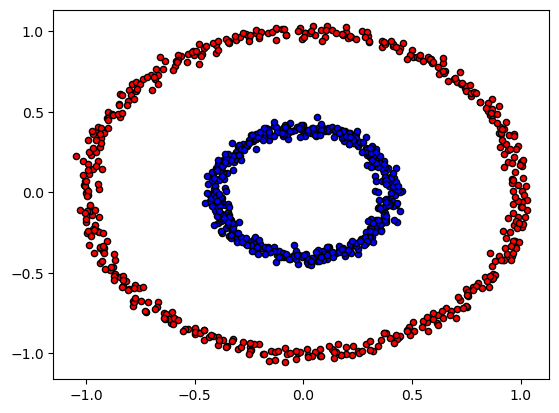

In [119]:
np.random.seed(42)

data, label = make_circles(n_samples=1000, factor = 0.4, noise = 0.025)


# Lets visualize the dataset
reds = label == 0
blues = label == 1
plt.scatter(data[reds, 0], data[reds, 1], c="red", s=20, edgecolor='k')
plt.scatter(data[blues, 0], data[blues, 1], c="blue", s=20, edgecolor='k')
plt.show()

In [120]:
import torch
from torch import nn
import torch.nn.functional as F

torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [121]:
X, y = data.astype(np.float32), label.astype(np.int64)
X.shape, y.shape

((1000, 2), (1000,))

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [123]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=2,
            hidden_dim=10,
            nonlin=F.relu,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.hidden_dim = hidden_dim
        self.nonlin = nonlin
        self.dropout = dropout

        self.hidden_layer = nn.Linear(input_dim, hidden_dim)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(hidden_dim, 2)

    def forward(self, X, **kwargs):
        hid = self.hidden_layer(X)
        hid_relu = self.nonlin(hid)
        hid_relu_drop = self.dropout(hid_relu)
        out = self.output_layer(hid_relu_drop)
        probs = F.softmax(out, dim=-1)
        return probs, out, hid_relu, hid

In [124]:
from skorch import NeuralNetClassifier

In [125]:
class ClassifierNet(NeuralNetClassifier):
    def get_loss(self, y_pred, y_true, *args, **kwargs):
        probs, output, hid_relu, hid = y_pred
        return super().get_loss(probs, y_true, *args, **kwargs)

In [126]:
net = ClassifierNet(
    ClassifierModule,
    max_epochs=100,
    lr=0.2)

In [127]:
net.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7103       0.6687        0.6878  0.0126
      2        0.7015       0.5375        0.6831  0.0115
      3        0.6938       0.6562        0.6808  0.0092
      4        0.6886       0.6875        0.6778  0.0104
      5        0.6854       0.6375        0.6734  0.0078
      6        0.6788       0.6062        0.6694  0.0061
      7        0.6786       0.6125        0.6662  0.0056
      8        0.6670       0.6562        0.6609  0.0054
      9        0.6668       0.6687        0.6554  0.0046
     10        0.6566       0.6875        0.6495  0.0042
     11        0.6649       0.7000        0.6446  0.0045
     12        0.6526       0.7438        0.6379  0.0054
     13        0.6525       0.8000        0.6325  0.0123
     14        0.6362       0.8250        0.6254  0.0066
     15        0.6444       0.8375        0.6205  0.0071
     16        0.6442       0.8

<class '__main__.ClassifierNet'>[initialized](
  module_=ClassifierModule(
    (hidden_layer): Linear(in_features=2, out_features=10, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (output_layer): Linear(in_features=10, out_features=2, bias=True)
  ),
)

In [128]:
# Making prediction for first 5 data points of X
y_pred = net.predict(X_test[:5])
y_pred

array([1, 0, 1, 0, 1])

In [129]:
y_out = net.forward(X_test[:5])
y_pred = y_out[1].numpy().argmax(1)
y_pred

array([1, 0, 1, 0, 1])

In [130]:
# Checking probarbility of each class for first 5 data points of X
y_proba = net.predict_proba(X[:5])
y_proba

array([[0.3116736 , 0.68832636],
       [0.2723142 , 0.7276858 ],
       [0.2840487 , 0.71595126],
       [0.30752748, 0.6924725 ],
       [0.737022  , 0.26297805]], dtype=float32)

In [131]:
y_pred = net.predict(X_test)
sum(y_test == y_pred)

200

In [132]:
dict(net.get_all_learnable_params())['hidden_layer.weight'].detach().numpy()

array([[-0.20179865,  0.25333002],
       [-0.09463232, -1.6795166 ],
       [-0.19454883,  0.13921843],
       [-0.15816805,  0.49770468],
       [-0.56638086,  1.4376572 ],
       [-1.0982188 , -0.25205684],
       [-0.6435225 , -0.2919859 ],
       [-0.29148576,  0.02619376],
       [ 1.6689777 ,  0.57608217],
       [-1.3109925 , -1.0064684 ]], dtype=float32)

In [133]:
model_data = {}

for param in net.get_all_learnable_params():
    model_data[param[0]] = param[1].detach().numpy().flatten()
    
model_data

{'hidden_layer.weight': array([-0.20179865,  0.25333002, -0.09463232, -1.6795166 , -0.19454883,
         0.13921843, -0.15816805,  0.49770468, -0.56638086,  1.4376572 ,
        -1.0982188 , -0.25205684, -0.6435225 , -0.2919859 , -0.29148576,
         0.02619376,  1.6689777 ,  0.57608217, -1.3109925 , -1.0064684 ],
       dtype=float32),
 'hidden_layer.bias': array([ 0.3320047 , -0.615842  , -0.2475579 ,  0.52835804, -0.53323054,
        -0.3867327 ,  0.6809727 , -0.655962  , -0.6575316 , -0.634221  ],
       dtype=float32),
 'output_layer.weight': array([-0.16733417,  1.1355488 , -0.17612639, -0.26283583,  0.91554666,
         0.5905259 , -0.06313699,  0.27182877,  1.2464685 ,  1.2454952 ,
         0.0606995 , -1.0244524 ,  0.02465491, -0.17799449, -1.3649727 ,
        -1.0497184 ,  0.07806212,  0.18541105, -1.2456074 , -1.1036384 ],
       dtype=float32),
 'output_layer.bias': array([-0.09474311,  0.6113626 ], dtype=float32)}

In [155]:
idx = 5

In [156]:
(X_test[idx]*(10**6)).round().astype(int)

array([ 321429, -305944])

In [157]:
y = net.forward(X_test[idx])
y

(tensor([0.2981, 0.7019]),
 tensor([-0.2475,  0.6090]),
 tensor([0.1896, 0.0000, 0.0000, 0.3252, 0.0000, 0.0000, 0.5635, 0.0000, 0.0000,
         0.0000]),
 tensor([ 0.1896, -0.1324, -0.3527,  0.3252, -1.1551, -0.6626,  0.5635, -0.7577,
         -0.2973, -0.7477]))

In [95]:
x = X_test[0]
y = net.forward(x)
y

(tensor([0.3000, 0.7000]),
 tensor([-0.3562,  0.4912]),
 tensor([0.4539, 0.0000, 0.0000, 0.7247, 0.0537, 0.0000, 0.6993, 0.0000, 0.0000,
         0.0000]),
 tensor([ 0.4539, -1.1644, -0.1654,  0.7247,  0.0537, -0.2726,  0.6993, -0.5943,
         -0.7660, -0.7356]))

In [96]:
net.forward(x)

(tensor([0.3000, 0.7000]),
 tensor([-0.3562,  0.4912]),
 tensor([0.4539, 0.0000, 0.0000, 0.7247, 0.0537, 0.0000, 0.6993, 0.0000, 0.0000,
         0.0000]),
 tensor([ 0.4539, -1.1644, -0.1654,  0.7247,  0.0537, -0.2726,  0.6993, -0.5943,
         -0.7660, -0.7356]))

In [97]:
in_json = {
    "input": (x*(10**6)).round().astype(int).tolist(),
    "hid_weights": (model_data['hidden_layer.weight']*(10**6)).round().astype(int).tolist(),
    "hid_bias": (model_data['hidden_layer.bias']*(10**12)).round().astype(int).tolist(),
    "out_weights":(model_data['output_layer.weight']*(10**6)).round().astype(int).tolist(),
    "out_bias": (model_data['output_layer.bias']*(10**18)).round().astype(int).tolist() # can also change to zero because we are doing argmax instead of softmax
}

In [68]:
in_json

{'input': [-181267, 336834],
 'hid_weights': [-201799,
  253330,
  -94632,
  -1679517,
  -194549,
  139218,
  -158168,
  497705,
  -566381,
  1437657,
  -1098219,
  -252057,
  -643523,
  -291986,
  -291486,
  26194,
  1668978,
  576082,
  -1310992,
  -1006468],
 'hid_bias': [332004696131,
  -615841984749,
  -247557893395,
  528358042240,
  -533230543137,
  -386732697487,
  680972695351,
  -655961990356,
  -657531619072,
  -634221017361],
 'out_weights': [-167334,
  1135549,
  -176126,
  -262836,
  915547,
  590526,
  -63137,
  271829,
  1246469,
  1245495,
  60699,
  -1024452,
  24655,
  -177994,
  -1364973,
  -1049718,
  78062,
  185411,
  -1245607,
  -1103638],
 'out_bias': [-94743110239505760, 611362576484680192]}

In [50]:
(y[1].numpy()*(10**18))

array([-3.56164843e+17,  4.91231829e+17])

In [69]:
out_json = {
    "scale": 10**-18,
    "out": (y[1].detach().numpy()*(10**18)).round().astype(int).tolist(),
    "label": int(y[1].argmax())
}
out_json

{'scale': 1e-18, 'out': [-356164842844009408, 491231828927993792], 'label': 1}

In [53]:
import json
with open("circle_input.json", "w") as f:
    json.dump(in_json, f)
with open("circle_output.json", "w") as f:
    json.dump(out_json, f)

In [99]:
with open('circle_fc_test.txt', 'w') as f:
    for key in in_json:
        f.write(key + " = [")
        for idx, value in enumerate(in_json[key]):
            if(idx!=0):
                f.write(', ')
            f.write('"' + str(value) + '"')
        f.write(']\n')


In [107]:
(y[2].numpy()*10**12).round().astype(int).tolist()

[453914284706, 0, 0, 724672555923, 53687512875, 0, 699271202087, 0, 0, 0]

In [158]:
(X_test*(10**6)).round().astype(int)

array([[ -181267,   336834],
       [    4443,   966478],
       [ -342958,  -151764],
       [ -293178,   962480],
       [  192460,  -394641],
       [  321429,  -305944],
       [  850645,   552831],
       [  999847,   189800],
       [ -367555,  -173140],
       [   55282,   977907],
       [ -481136,   796966],
       [  -91968,   352019],
       [  966399,   359227],
       [ -281583,  -308476],
       [ -919316,  -252760],
       [  374433,   -47643],
       [  197512,   332326],
       [ -686810,   713735],
       [ -284807,   267009],
       [ -841971,   465137],
       [    8279,   989227],
       [ 1005008,  -212258],
       [ -331449,   214292],
       [ -841805,   607126],
       [  644762,   743086],
       [  899288,   366547],
       [ -245009,  -962478],
       [  860271,  -518446],
       [ -988762,  -240288],
       [ -206211,  -297599],
       [  302932,   238234],
       [  591095,   803354],
       [ -402363,   865038],
       [   40283,  -407915],
       [ -5042

In [160]:
predictions = net.predict(X_test)

In [183]:
n_samples = X_test.shape[0]
model_name = 'circle_fc'

with open(f"tests_{model_name}.txt", 'w') as f:
    for i in range(len(X_test[:n_samples])):
        f.write('#[test]\n')
        f.write(f"fn test_{model_name}_{i+1:03d}" + "() {\n")
        f.write("  let sample = [")
        for idx, value in enumerate(X_test[i]):
            if(idx!=0):
                f.write(', ')
            f.write(str((value*(10**6)).round().astype(int)))
        f.write('];\n')
        f.write(f"  assert({model_name}(sample) == " + str(predictions[i]) + ");\n")
        f.write('}\n\n')